In [ ]:
from skimage import io, filters, feature, morphology, exposure
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.draw import rectangle_perimeter, circle_perimeter
from pathlib import Path
from matplotlib.patches import Circle
import cv2
import matplotlib.pyplot as plt
from glob import glob
import imageio.v2 as imageio
import os
import pandas as pd
from skimage import io, measure, filters, exposure, feature, morphology

In [ ]:
input_dir = Path("Datasets\\enhanced_images")
input_files = list(input_dir.glob("*.png"))
print(input_files.__len__())

for img_p in input_files:
    # Load the enhanced PNG image
    image_path = Path(img_p)
    print(image_path)

35
Datasets\enhanced_images\Raw_Observation_001_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_002_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_003_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_004_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_005_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_006_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_007_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_008_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_009_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_010_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_011_Set1_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_012_Set2_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_013_Set2_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_014_Set2_enhanced_plot.png
Datasets\enhanced_images\Raw_Observation_015_

In [13]:
# Helper: Display and Save Image as Plot
def show_image(img, save_path=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

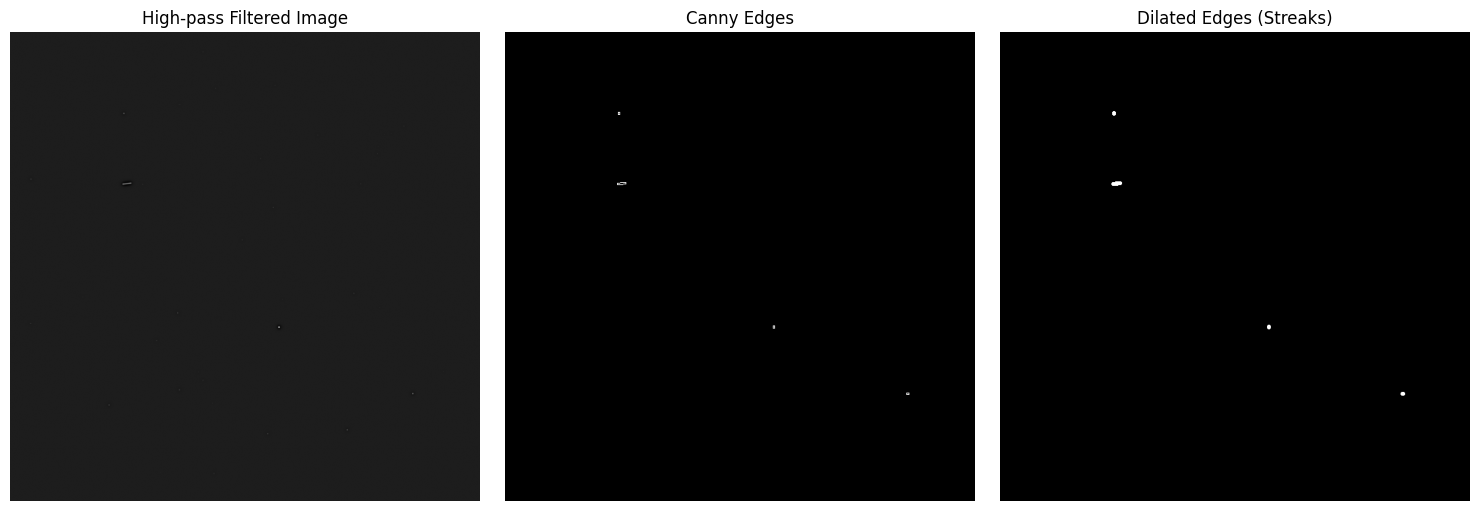

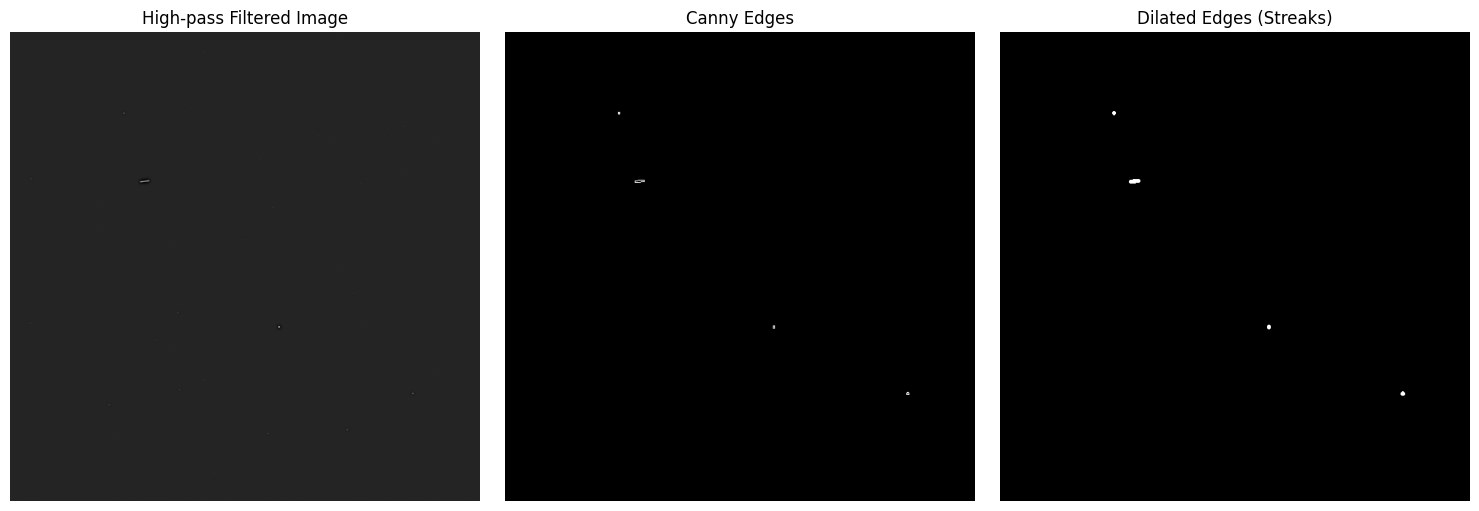

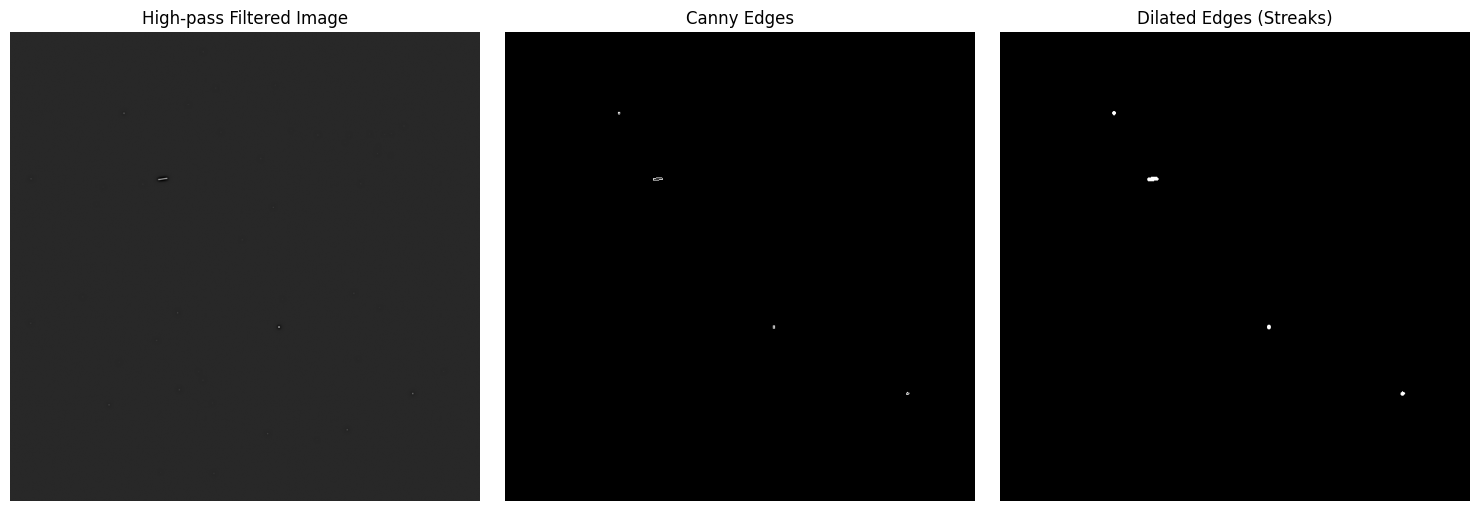

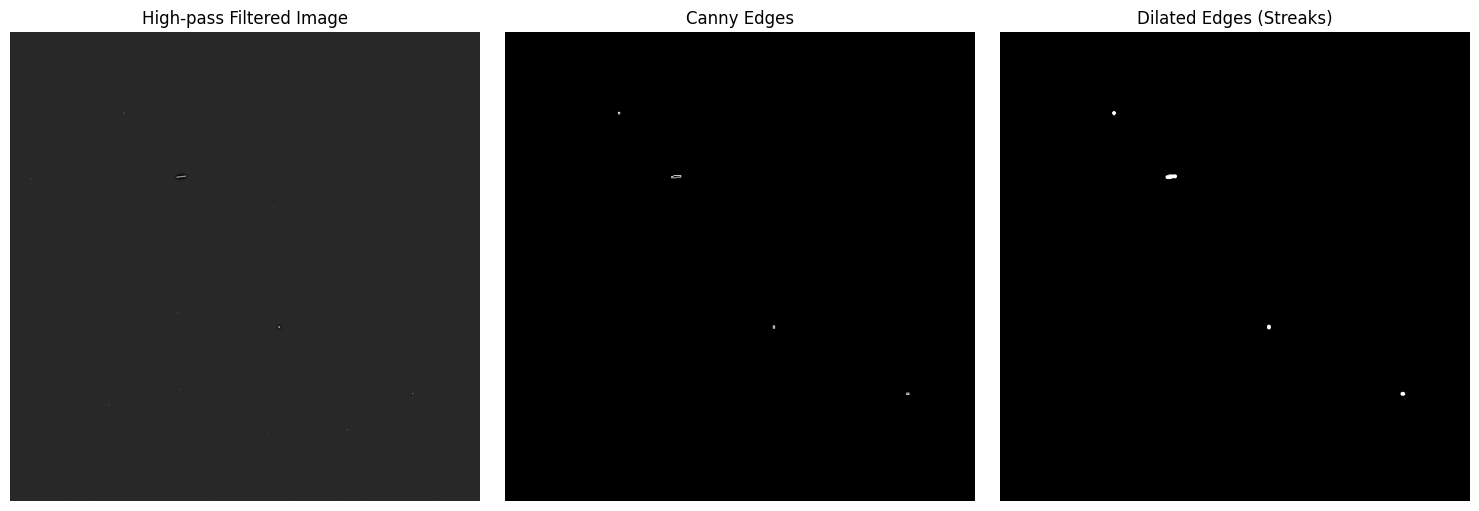

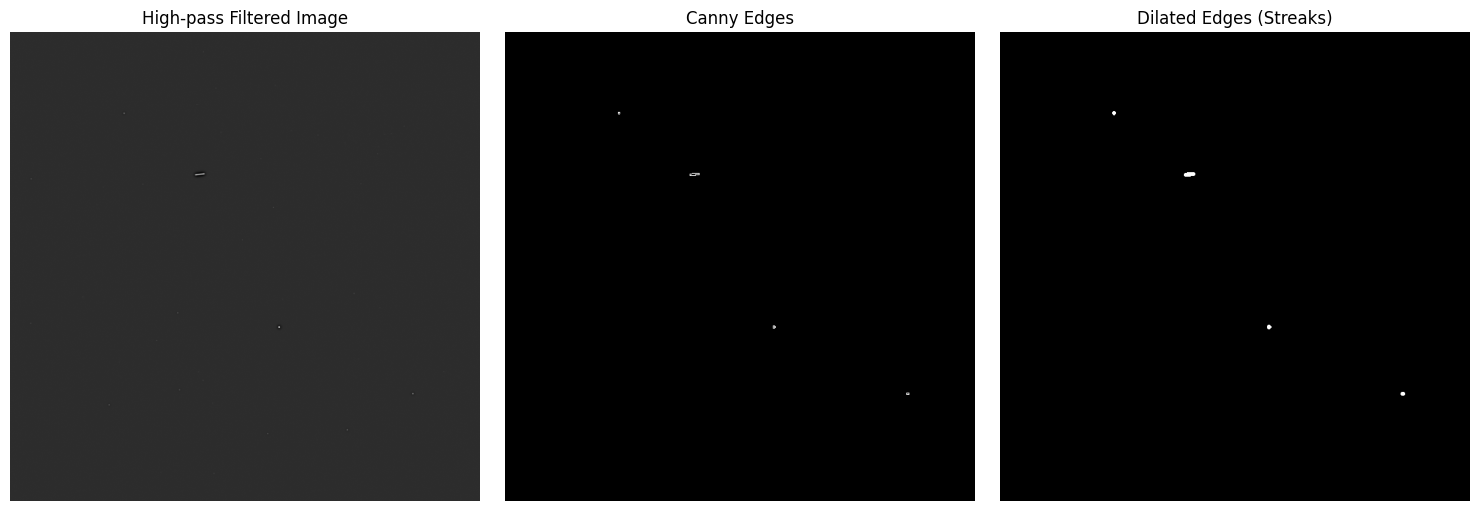

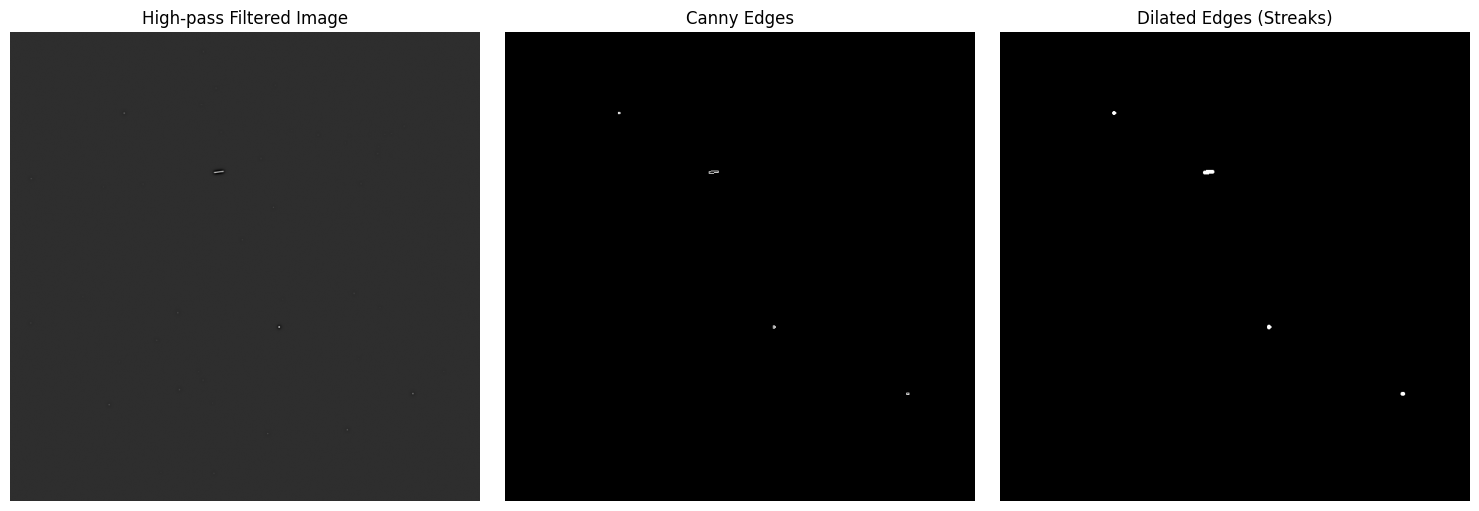

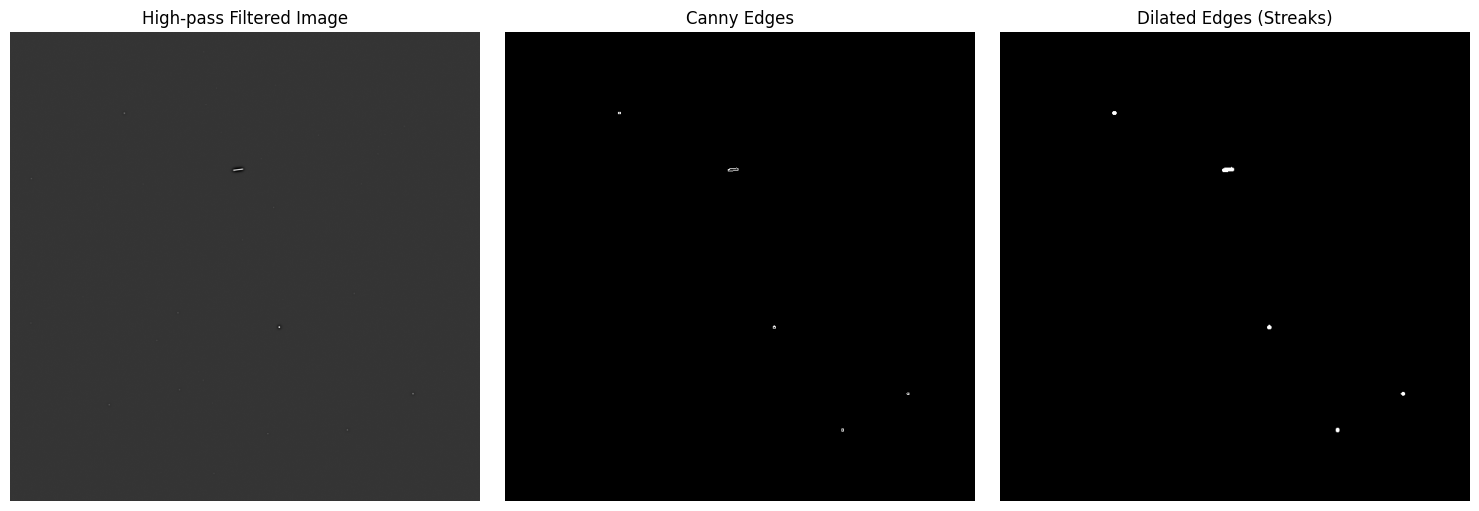

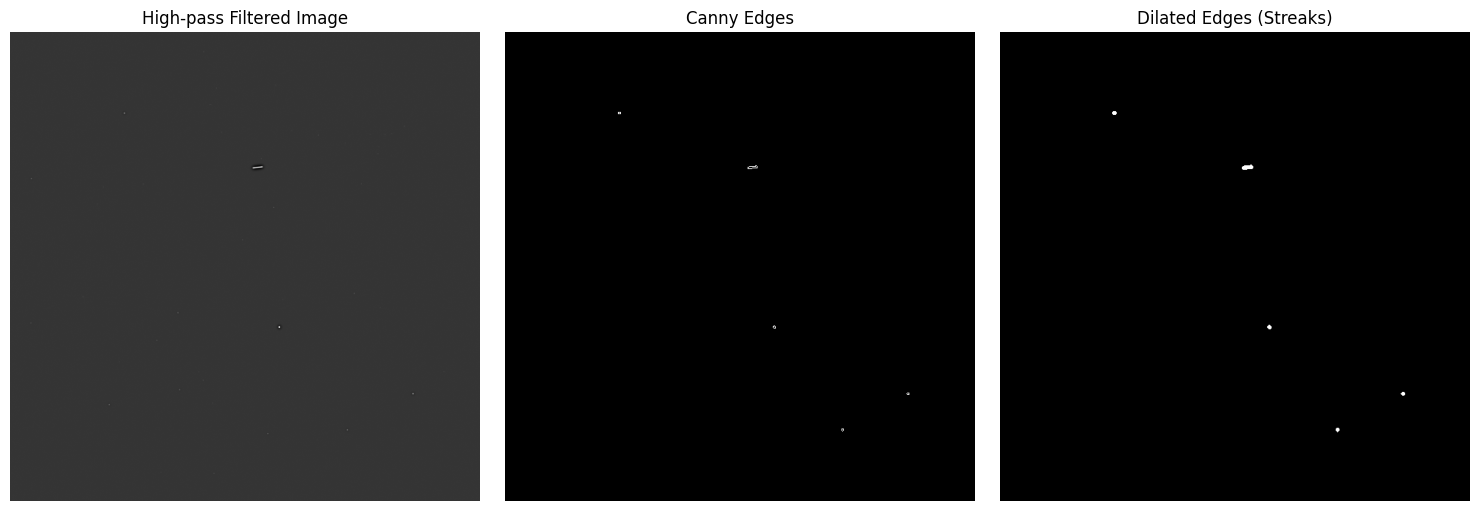

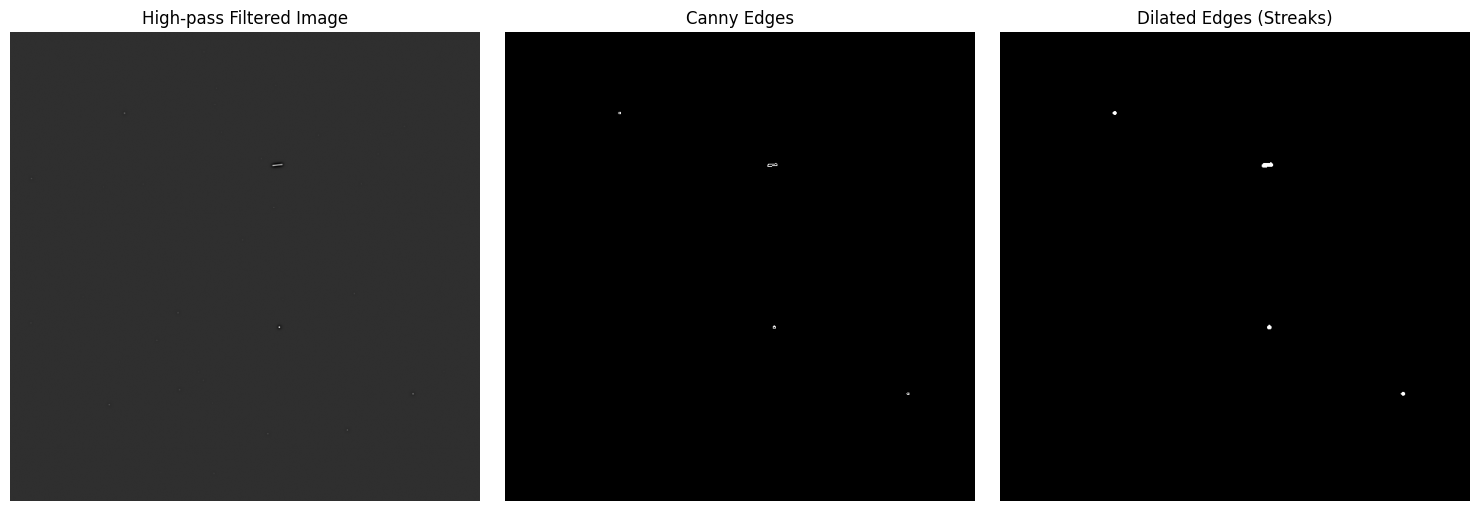

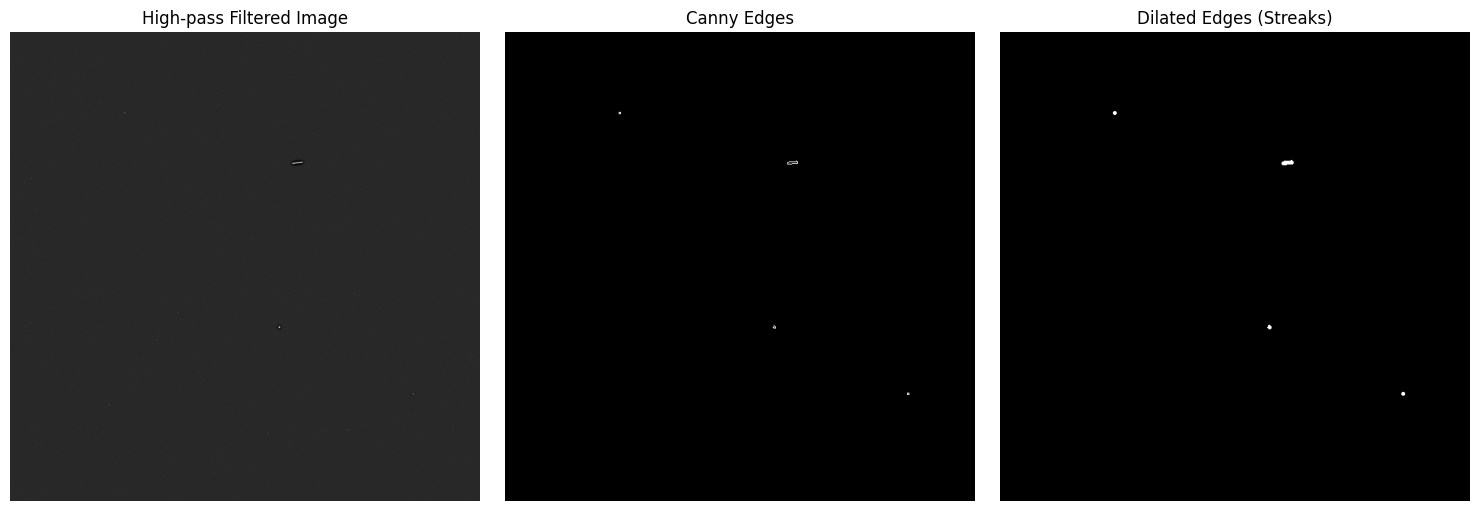

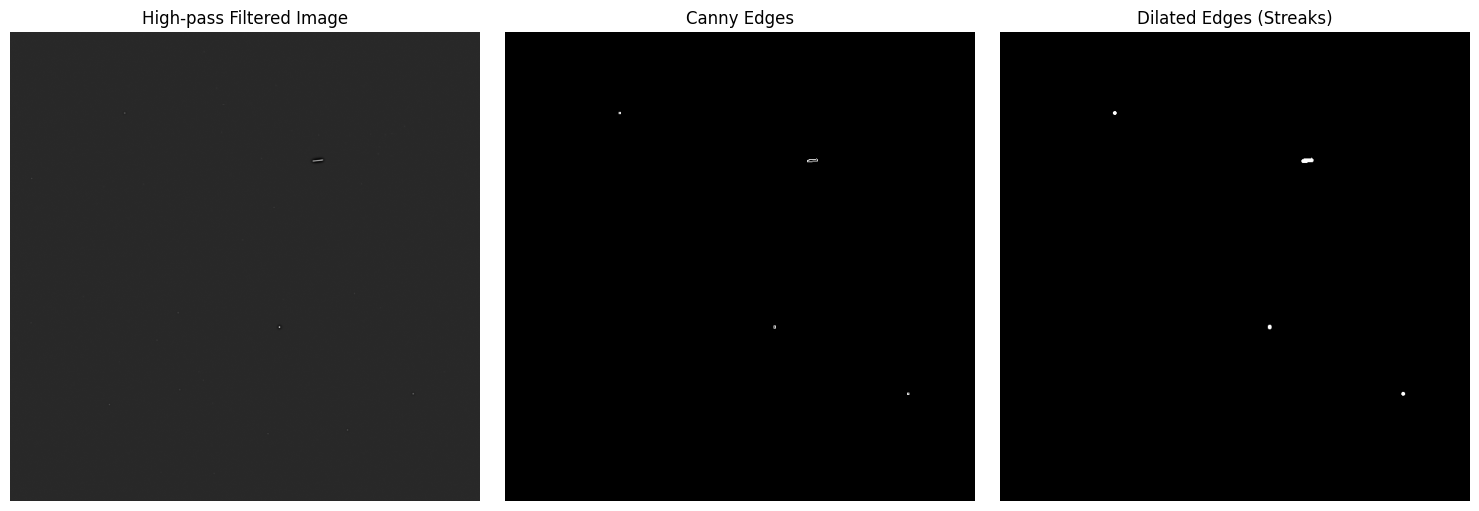

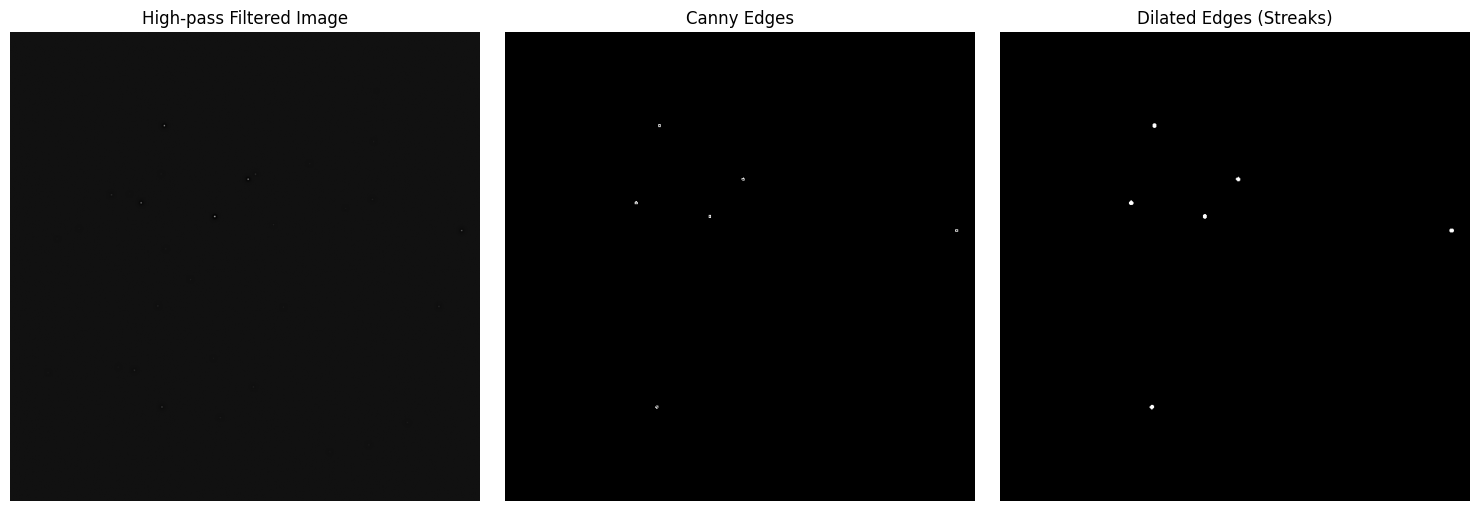

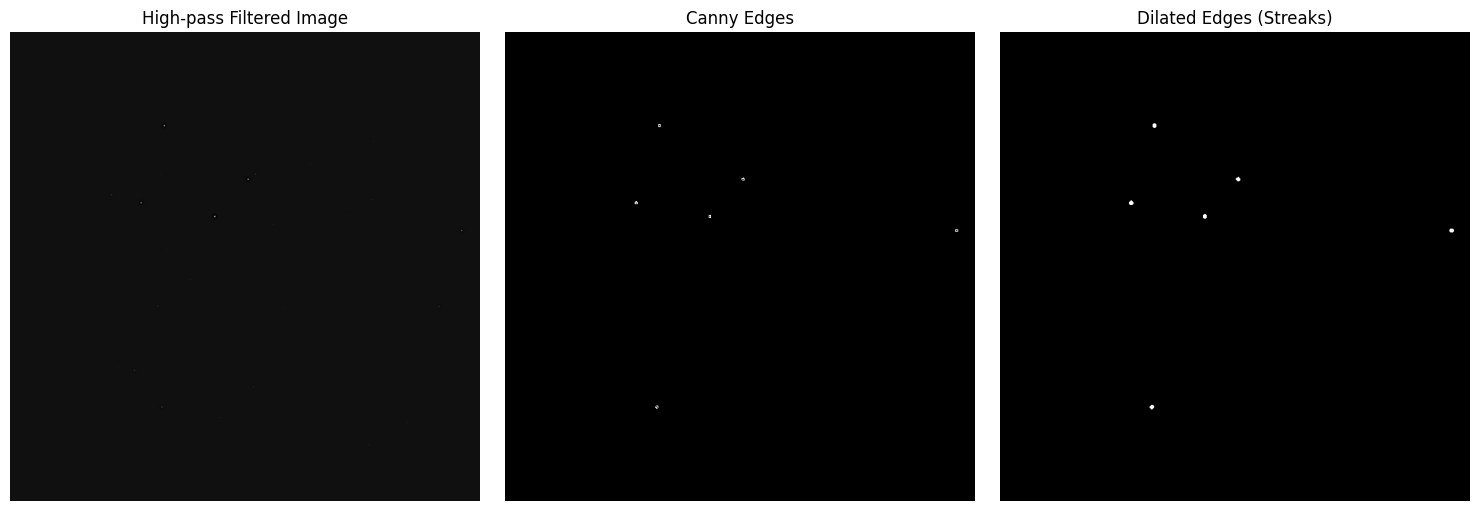

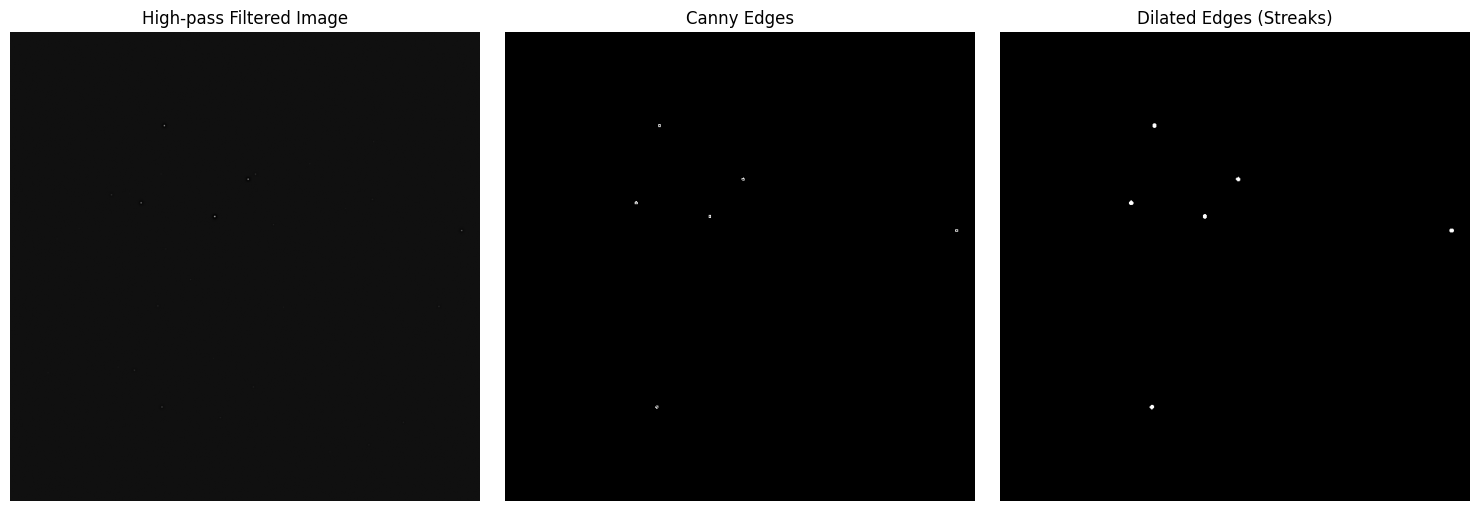

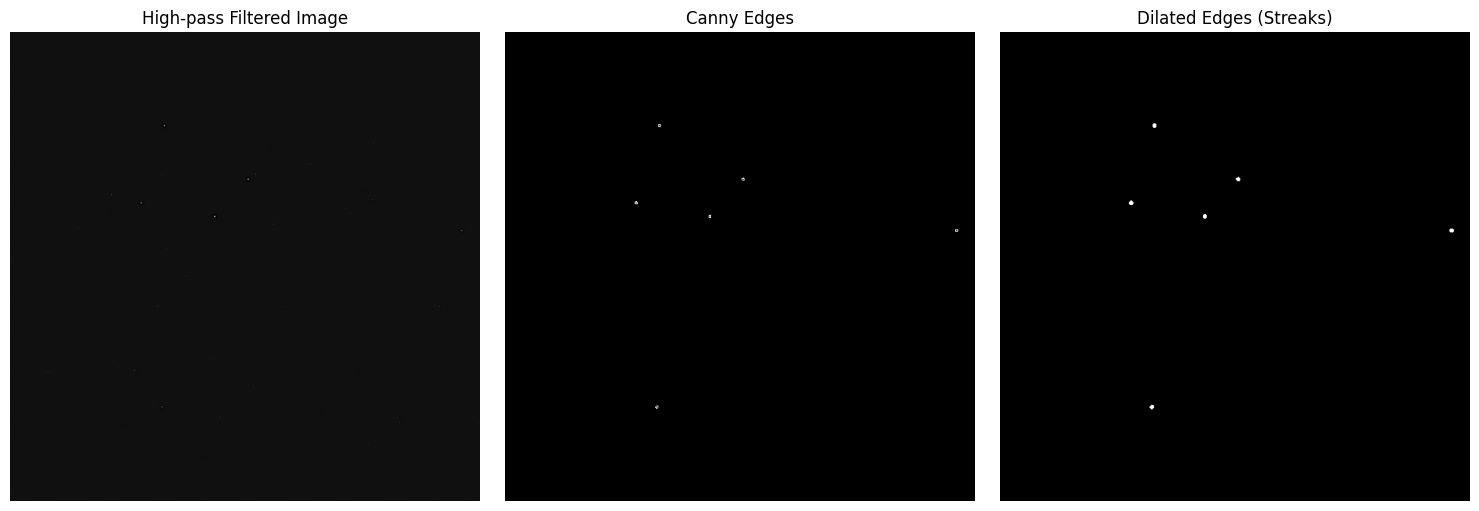

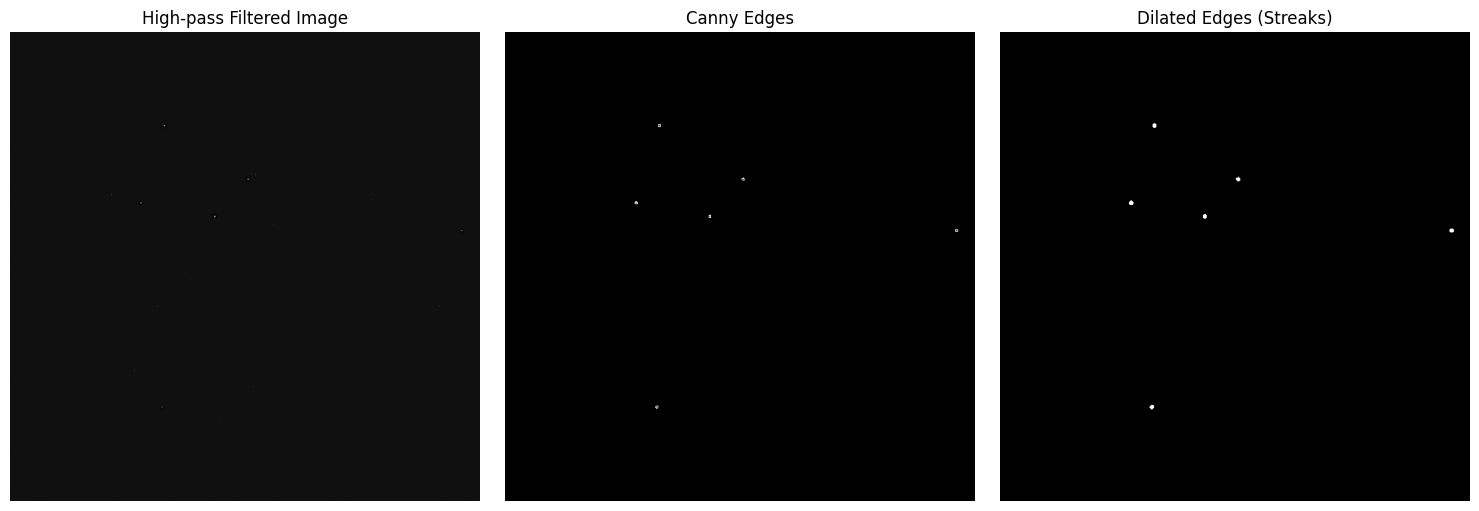

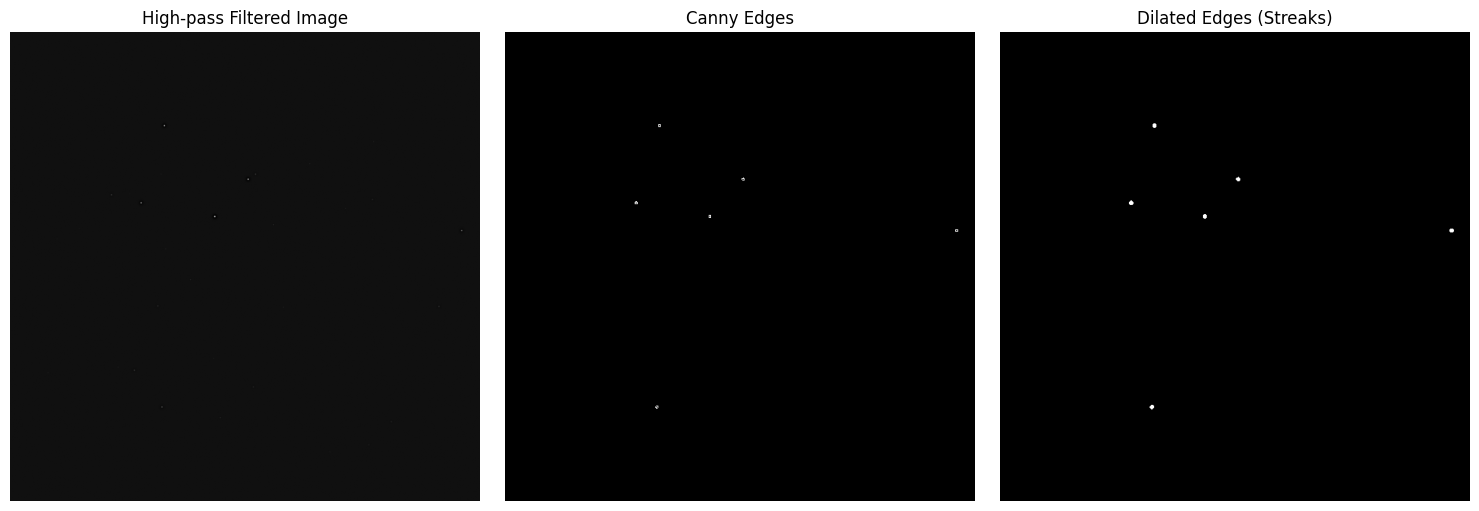

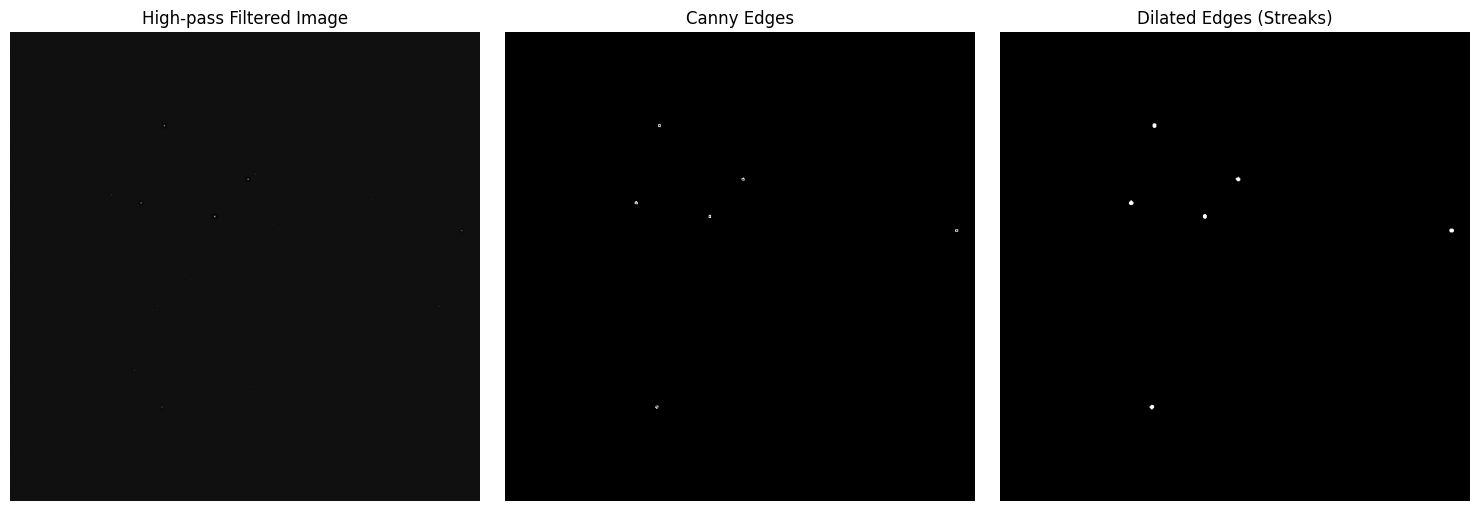

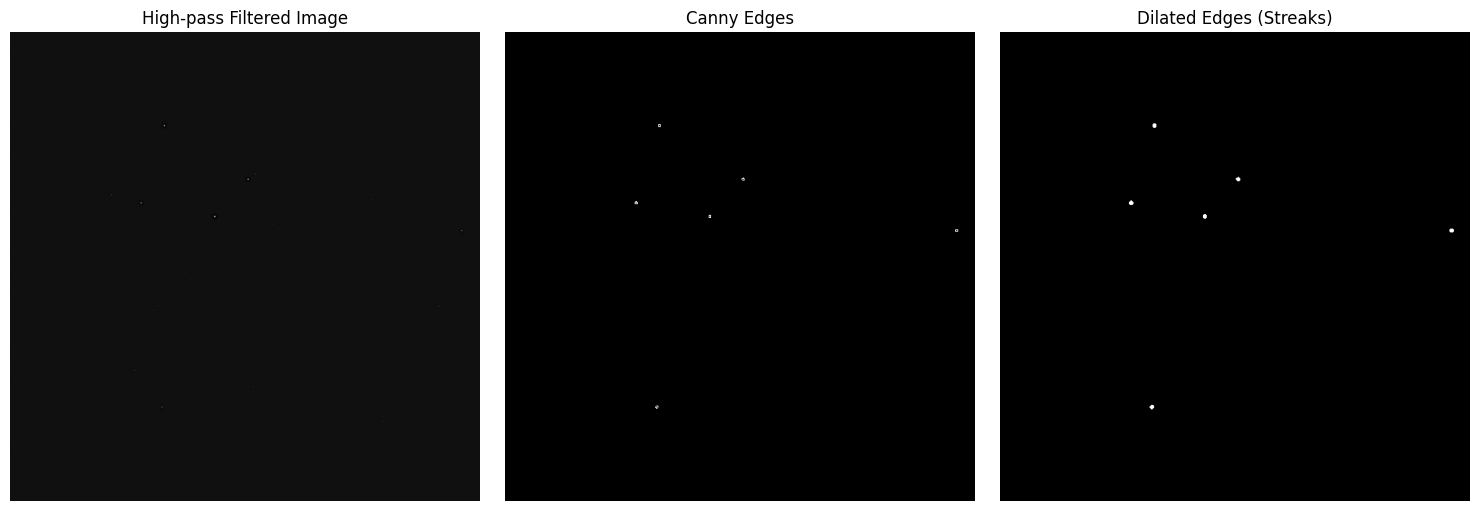

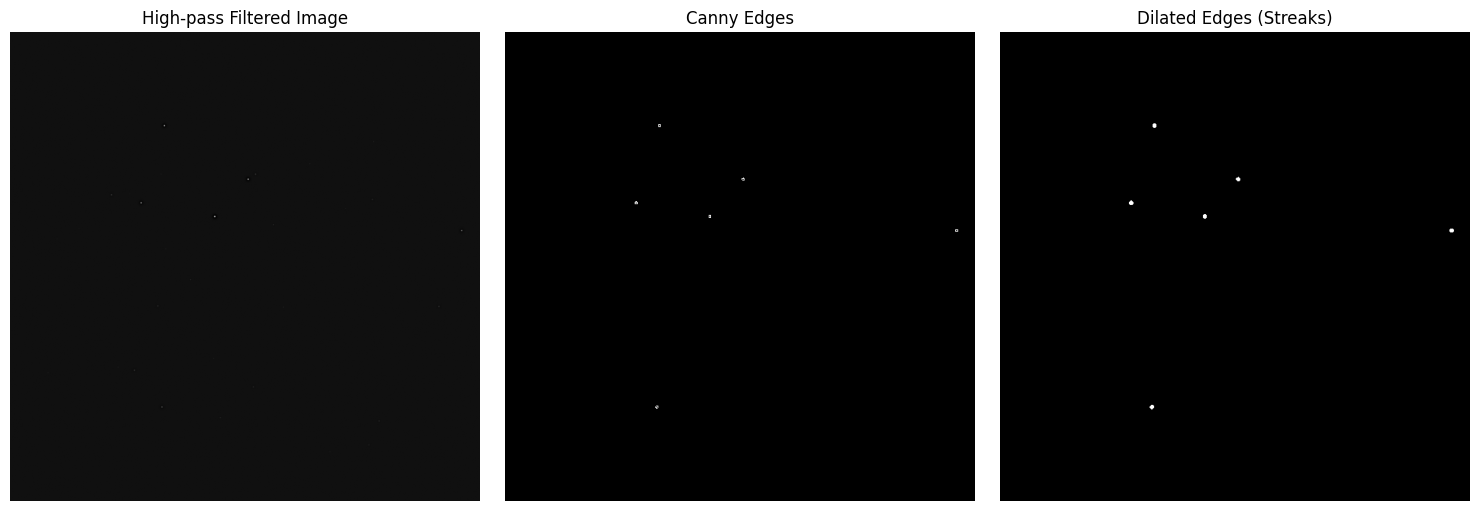

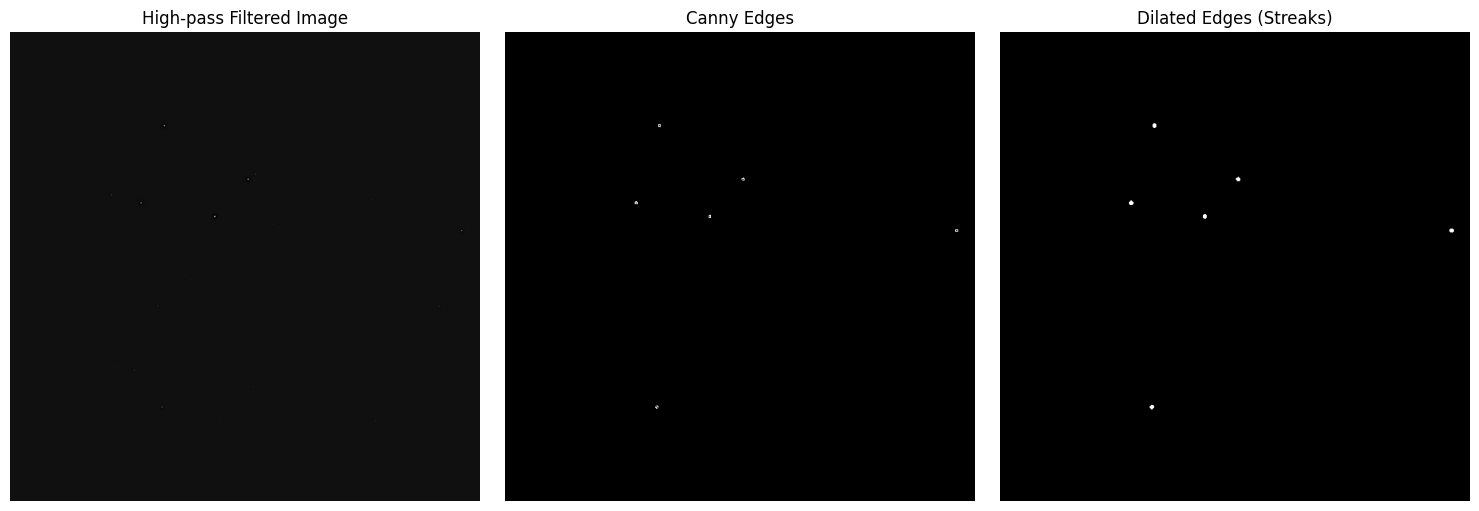

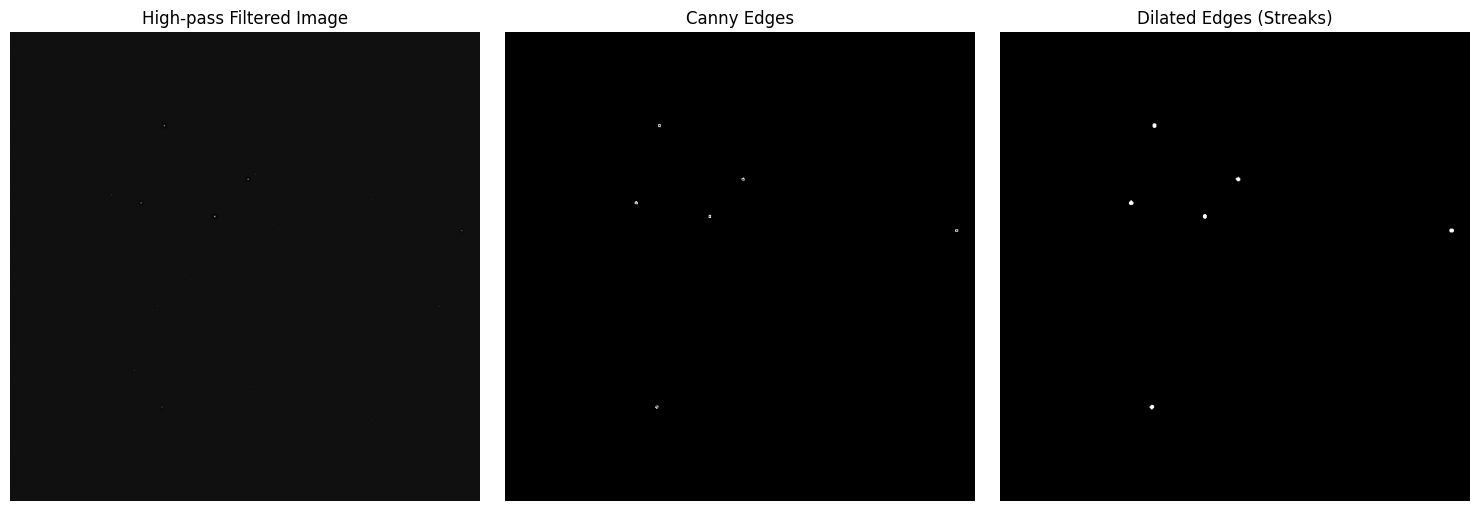

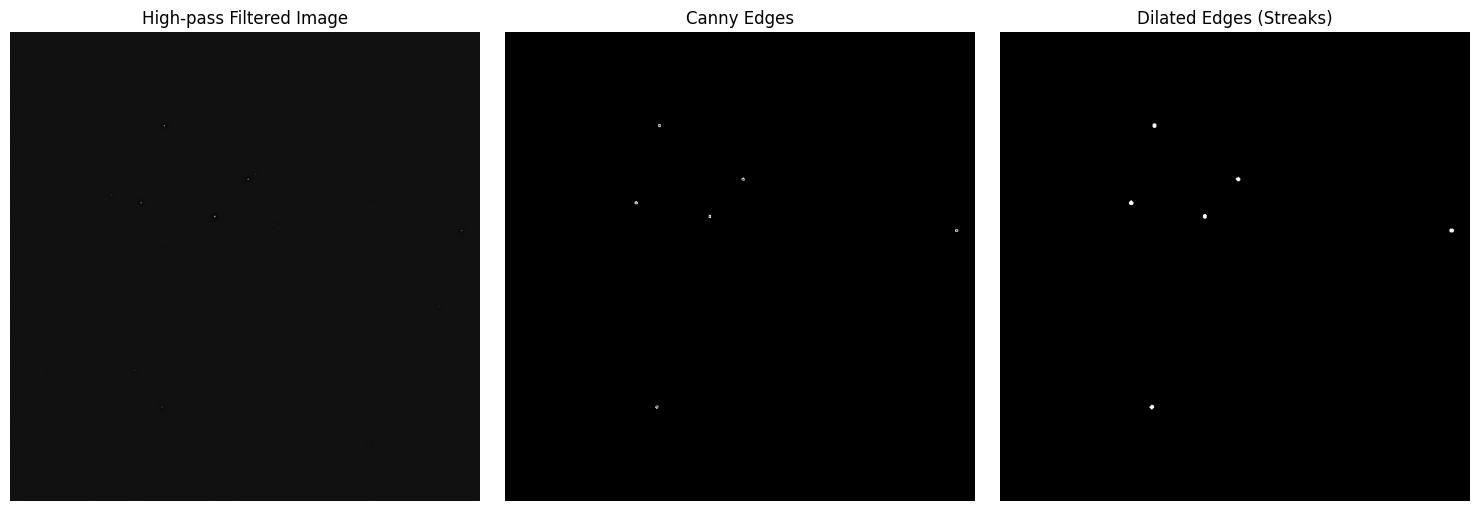

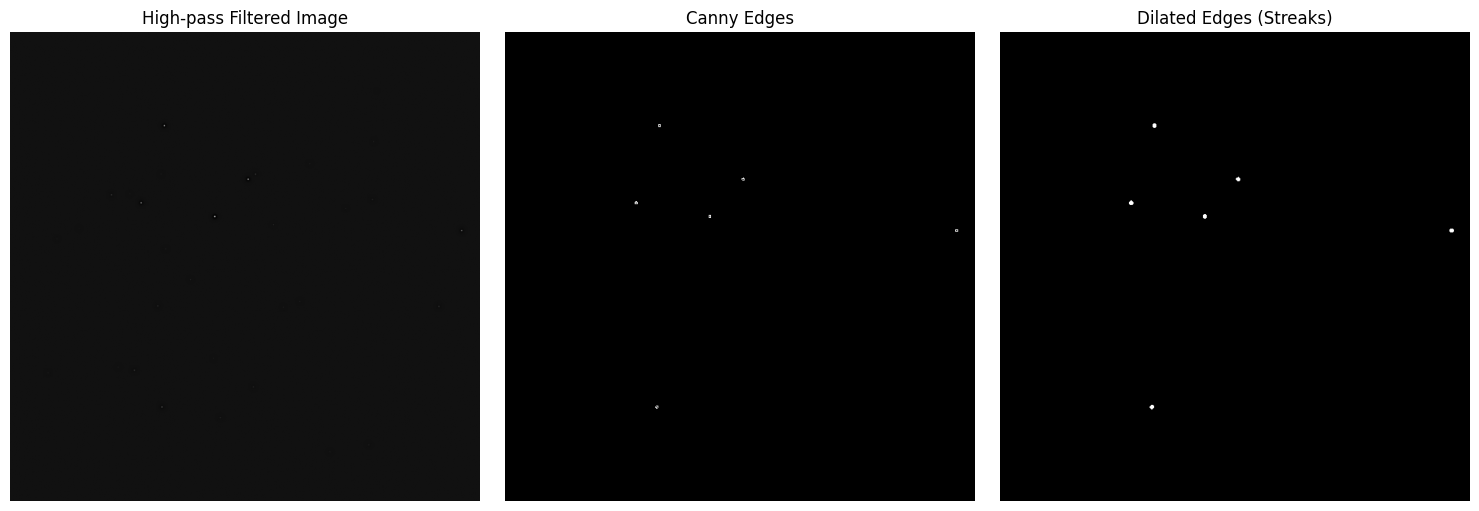

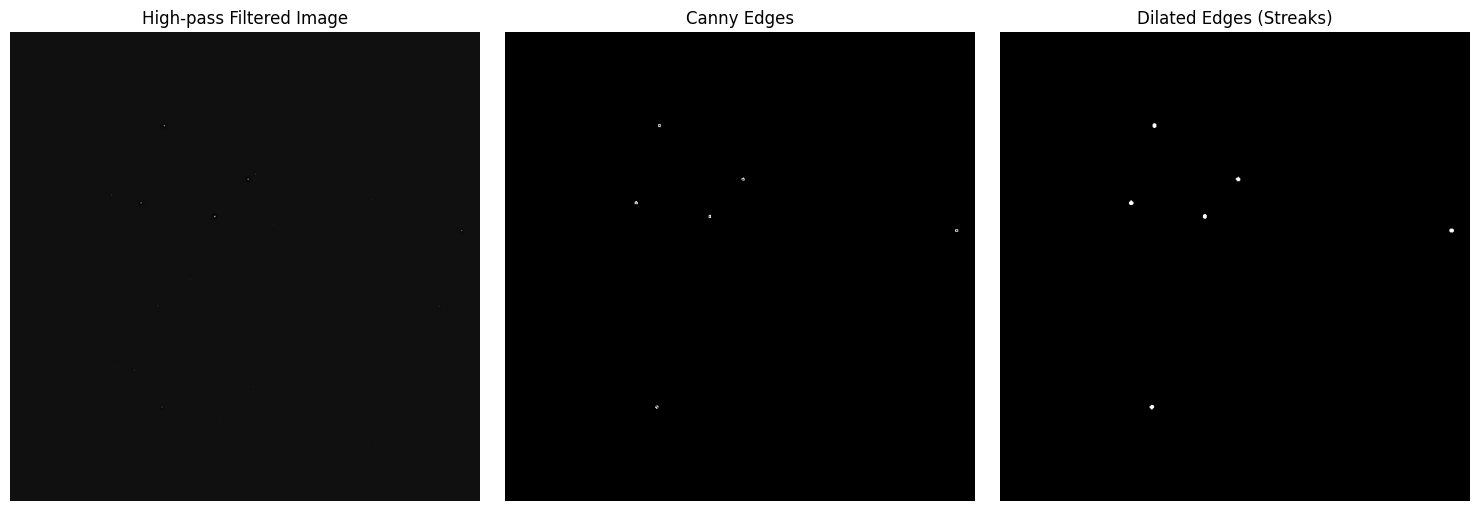

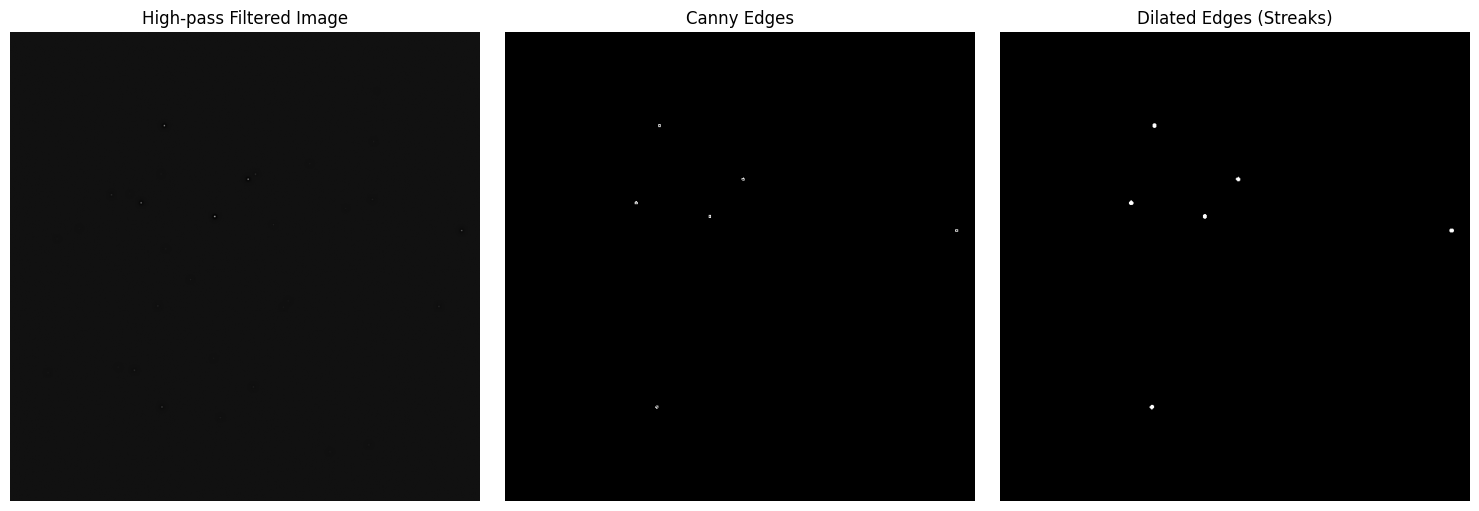

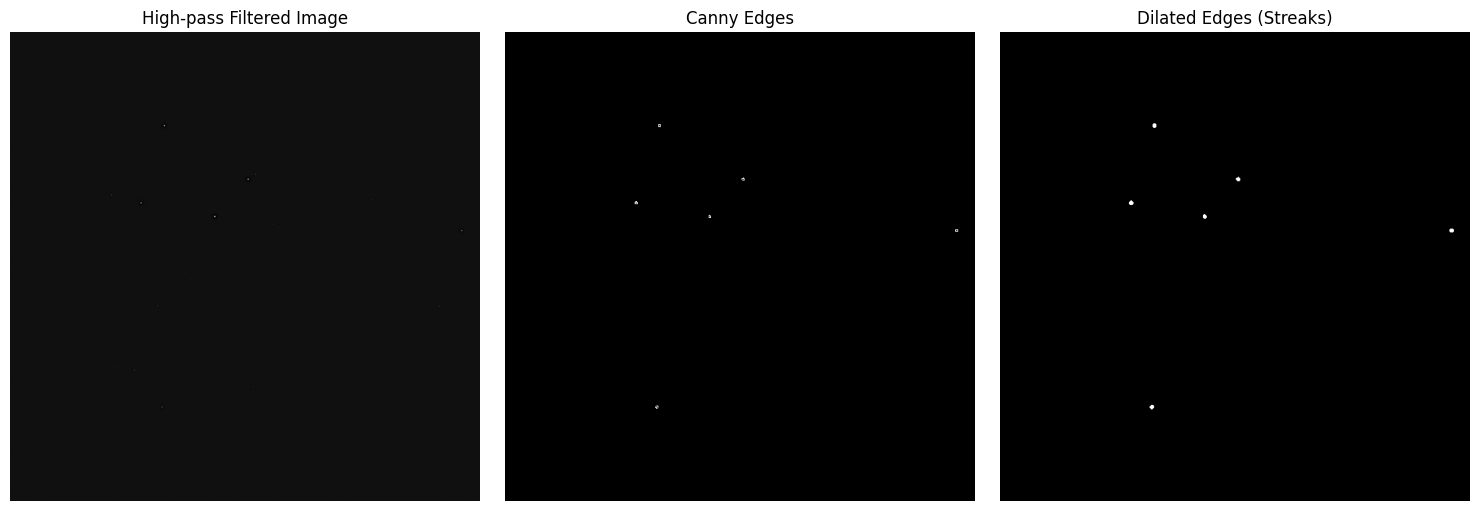

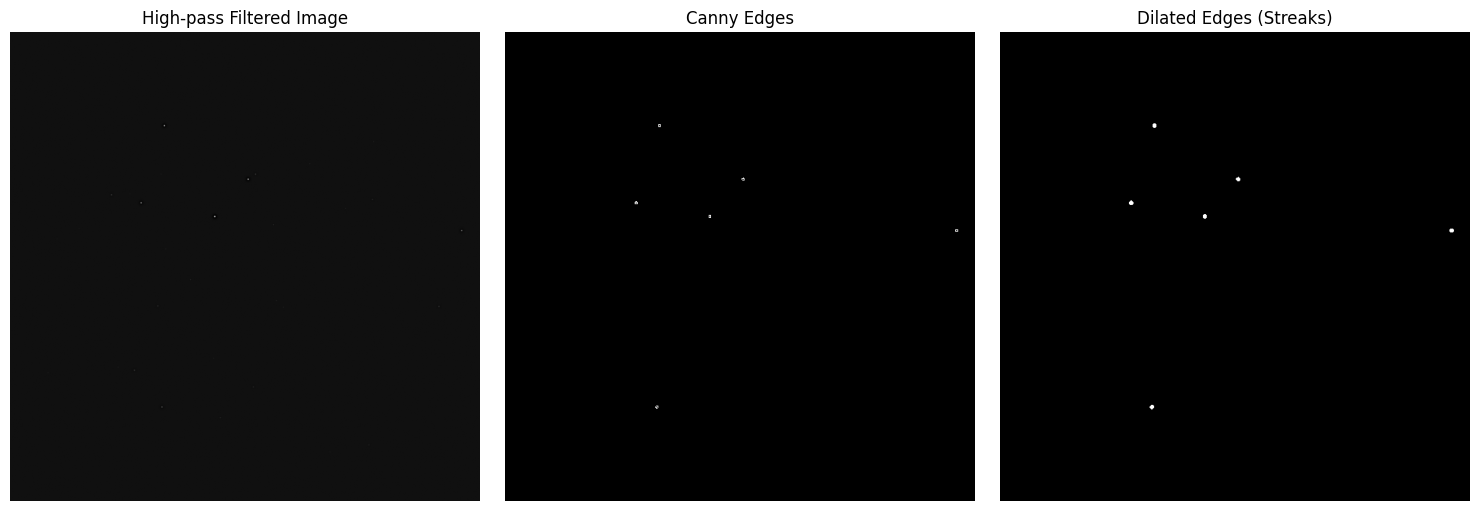

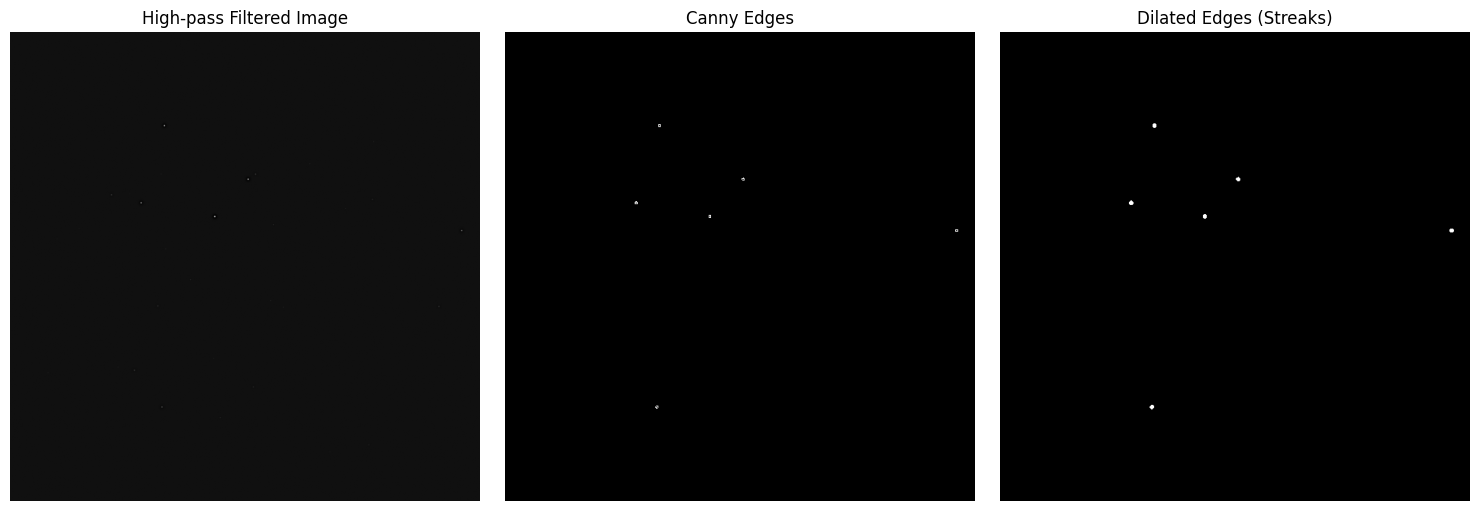

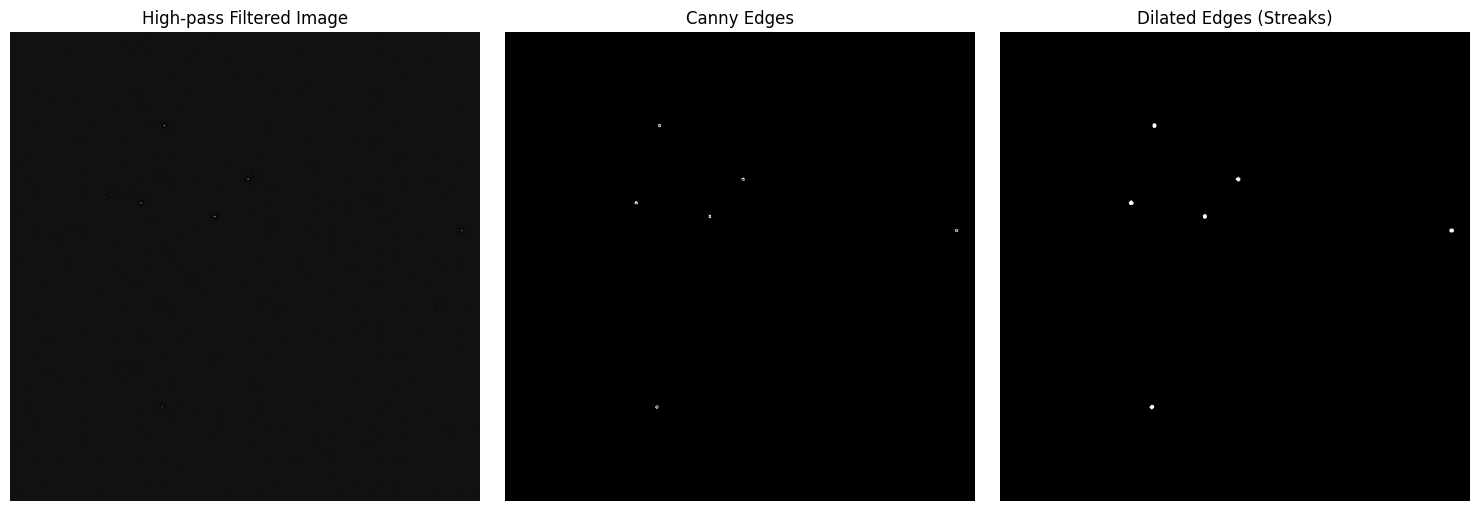

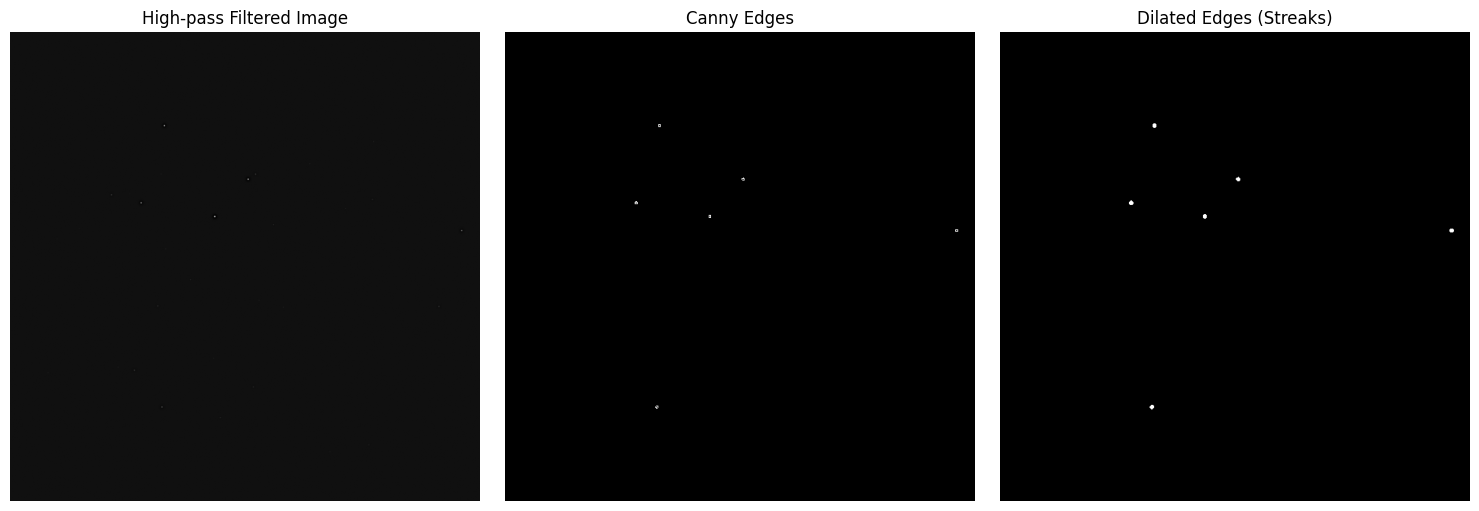

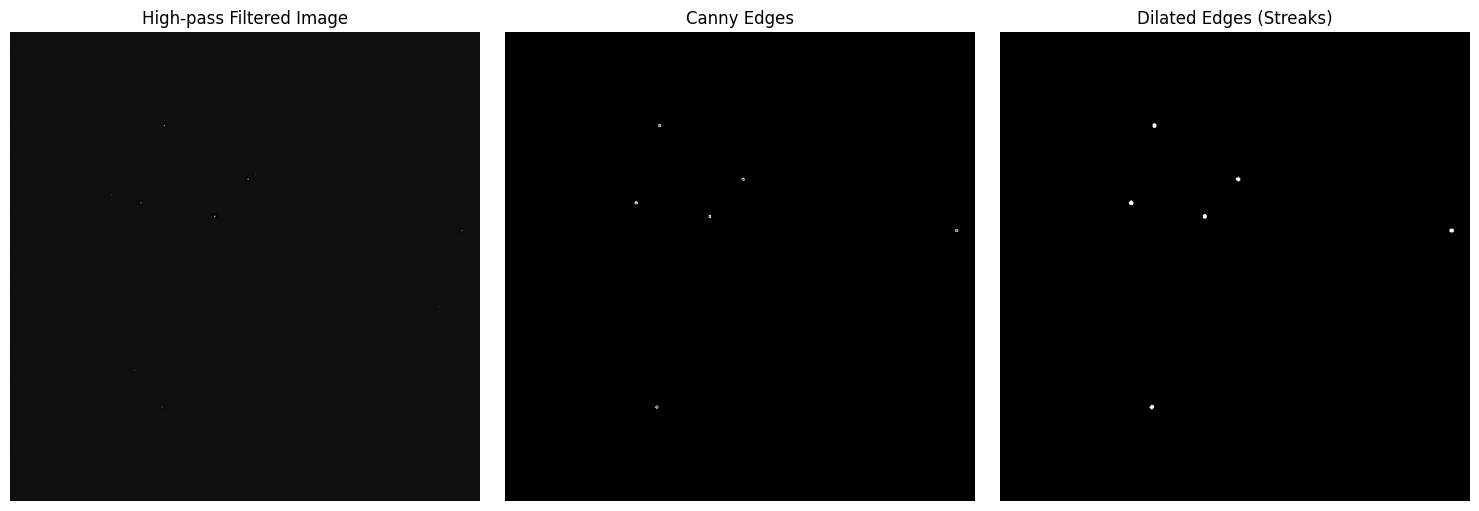

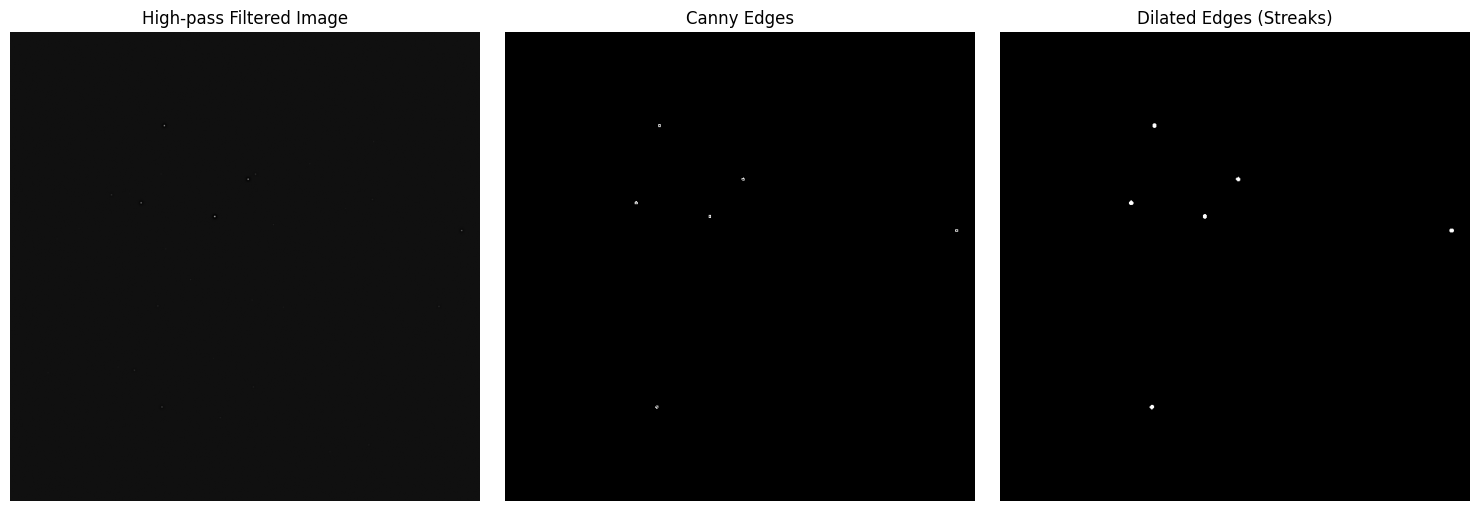

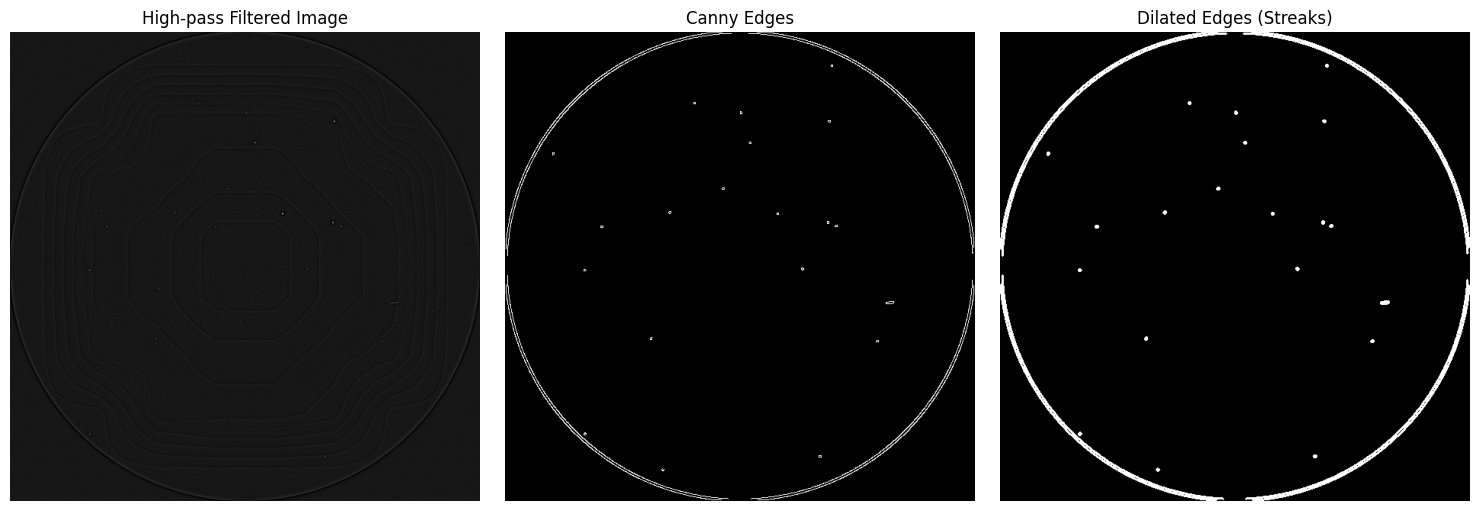

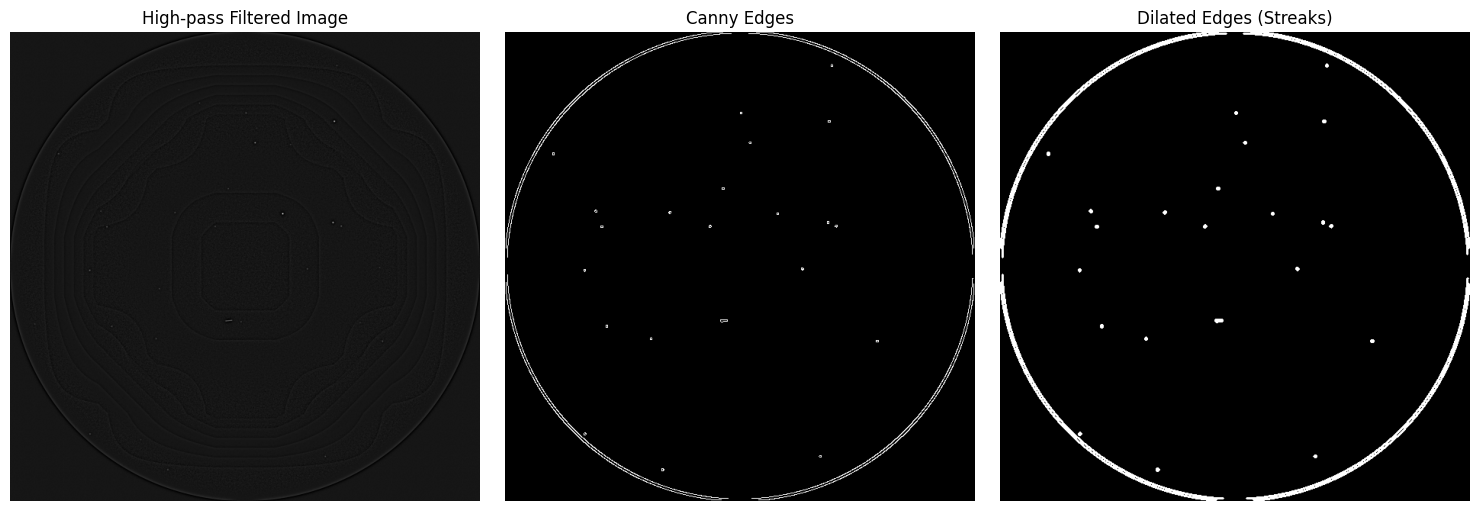

In [21]:
for img_p in input_files:
    # Load the enhanced PNG image
    image_path = Path(img_p)
    image = io.imread(image_path, as_gray=True)

    # Apply Gaussian blur for high-pass filtering
    blurred = filters.gaussian(image, sigma=2)
    highpass = image - blurred

    # Enhance contrast for better edge detection
    highpass_eq = exposure.equalize_adapthist(highpass)

    # Detect edges using Canny
    edges = feature.canny(highpass_eq, sigma=1)

    # Apply morphological operations to strengthen streaks
    edges_dilated = morphology.dilation(edges, morphology.disk(1))

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(highpass, cmap='gray')
    axes[0].set_title("High-pass Filtered Image")
    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title("Canny Edges")
    axes[2].imshow(edges_dilated, cmap='gray')
    axes[2].set_title("Dilated Edges (Streaks)")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Label connected regions
    labels = measure.label(edges_dilated)
    regions = measure.regionprops(labels)

    # Plot with bounding rectangles
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    for region in regions:
        if region.area > 40:  # Filter out small noise regions
            minr, minc, maxr, maxc = region.bbox
            rr, cc = rectangle_perimeter(start=(minr, minc), end=(maxr, maxc), shape=image.shape)
            ax.plot(cc, rr, color='white', linewidth=1)

        elif region.area < 30:  # Filter out small noise regions
            cy, cx = region.centroid
            radius = np.sqrt(region.area / np.pi)*2
            circ = Circle((cx, cy), radius, edgecolor='white', facecolor='none', linewidth=1)
            ax.add_patch(circ)

    plt.axis('off')
    # Save figure using image filename
    output_path = f"Datasets/output_with_annotations/{image_path.stem}_annotated.png"
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

In [ ]:
# Input directory and output CSV
input_dir = "Datasets/enhanced_images"
output_csv = "annotation_data/annotations.csv"

# Prepare the annotation list
annotations = []

# List all PNG images
image_paths = list(Path(input_dir).glob("*.png"))

for image_path in image_paths:
    # Load image
    image = io.imread(image_path, as_gray=True)
    filename = image_path.name

    # High-pass filtering
    blurred = filters.gaussian(image, sigma=2)
    highpass = image - blurred
    highpass_eq = exposure.equalize_adapthist(highpass)

    # Edge detection and morphological dilation
    edges = feature.canny(highpass_eq, sigma=1)
    edges_dilated = morphology.dilation(edges, morphology.disk(1))

    # Label connected regions
    labels = measure.label(edges_dilated)
    regions = measure.regionprops(labels)

    for region in regions:
        area = region.area

        if area > 40:
            # Streak (rectangle)
            minr, minc, maxr, maxc = region.bbox
            annotations.append({
                "image": filename,
                "x_min": int(minc),
                "y_min": int(minr),
                "x_max": int(maxc),
                "y_max": int(maxr),
                "label": "streak"
            })

        elif area < 30:
            # Star (circle -> approximate bounding box)
            cy, cx = region.centroid
            radius = np.sqrt(area / np.pi) * 2
            x_min = int(cx - radius)
            y_min = int(cy - radius)
            x_max = int(cx + radius)
            y_max = int(cy + radius)
            annotations.append({
                "image": filename,
                "x_min": x_min,
                "y_min": y_min,
                "x_max": x_max,
                "y_max": y_max,
                "label": "star"
            })

# Save to CSV
df = pd.DataFrame(annotations)
df.to_csv(output_csv, index=False)
print(f"Saved {len(df)} annotations to {output_csv}")

Saved 228 annotations to annotations.csv
